<a href="https://colab.research.google.com/github/Pablo7776/TrabajoFinalBigDataGrupo16/blob/main/armas3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****************************************************************************************************************************************************************
# Clasificador de Modelos de Armas según su Sonido de Disparo
****************************************************************************************************************************************************************


##Grupo 16
##Pablo Durán
##Ezequiel Flores

## Contexto del Problema
El proyecto busca desarrollar un sistema capaz de clasificar diferentes tipos de armas basándose en el sonido de sus disparos. Esto implica el análisis y procesamiento de señales de audio para identificar características distintivas que permitan la clasificación precisa de cada tipo de arma.

## Importancia y Relevancia
La clasificación de armas basada en el sonido de disparo tiene aplicaciones importantes en campos como la seguridad pública, la defensa y la aplicación de la ley. Un sistema preciso y confiable podría ayudar a identificar el tipo de arma utilizada en eventos como tiroteos, lo que podría ser crucial para la investigación y resolución de casos.


## Objetivos del Proyecto
- Desarrollar un modelo de aprendizaje automático capaz de clasificar diferentes tipos de armas basándose en el sonido de sus disparos.
- Entrenar y validar el modelo utilizando un conjunto de datos amplio y diverso que represente fielmente las características de los sonidos de disparo.
- Evaluar la precisión y eficacia del modelo en la clasificación de diferentes tipos de armas.

In [111]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import random
from IPython.display import Audio
import librosa
import librosa.display

##Datos Utilizados:

https://www.kaggle.com/datasets/emrahaydemr/gunshot-audio-dataset/code

Los audios de los modelos de armas se recopilaron en YouTube mediante vídeos abiertos a todo el mundo. Estos archivos recopilados en diferentes fechas se descargaron  para cada tipo de arma. De esta forma se obtuvieron un total de 9 modelos de pistola.
La frecuencia de muestreo de los archivos de audio es de 44100 Hz y cada archivo de audio se convirtió al formato de archivo WAV, por lo tanto su calidad no es del todo óptima.

In [112]:

# Definir la lista de carpetas que contienen los archivos de audio
carpetas_base = '/content/drive/MyDrive/Colab Notebooks/ELEMENTOS DE APRENDIZAJE DE MÁQUINA Y BIG DATA/armas/'

subcarpetas = ['AK-12', 'AK-47', 'IMI Desert Eagle', 'M16', 'M249', 'M4', 'MG-42', 'MP5', 'Zastava M92']
carpetas = [os.path.join(carpetas_base, subcarpeta) for subcarpeta in subcarpetas]

In [113]:
audio1 = carpetas_base + '/AK-12' + '/3 (1).wav'


## Feature extraction

Tomemos un único audio a modo de ejemplo ilustrativo antes de aplicar el feature extraction en todos los audios.


para más opciones ver documentación de librosa:

https://librosa.org/doc/latest/feature.html

In [114]:
Audio(audio1)

<class 'numpy.ndarray'> <class 'int'>


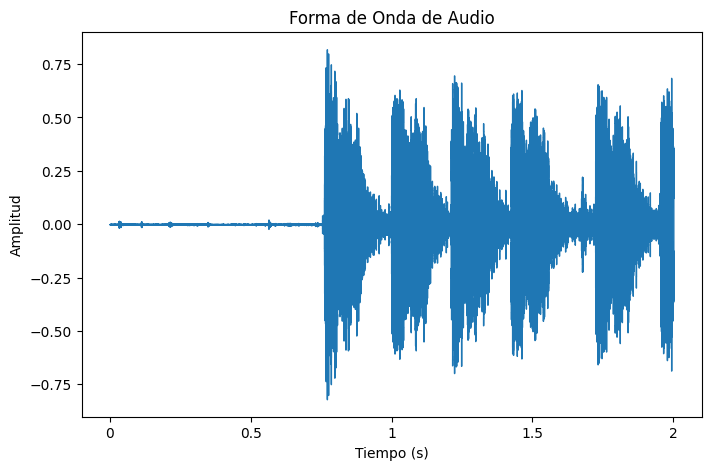

In [115]:
x , sr = librosa.load(audio1)
print(type(x), type(sr))
# Mostrar la forma de onda usando matplotlib
plt.figure(figsize=(8, 5))
librosa.display.waveshow(x, sr=sr)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Forma de Onda de Audio')
plt.show()

##RMS "Root Mean Square"

 En el contexto del procesamiento de señales de audio, el valor RMS se utiliza comúnmente para medir la energía promedio de una señal a lo largo del tiempo.

El valor RMS proporciona una medida de la amplitud promedio de la señal, lo que puede ser útil para caracterizar la energía o la intensidad de la señal de audio. En el contexto de la música y el audio, el valor RMS se utiliza a menudo para normalizar el volumen de las pistas de audio y para medir la potencia de una señal eléctrica representativa de la señal de audio.

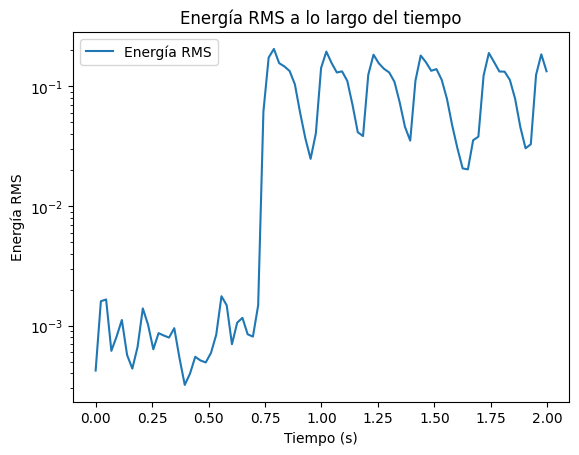

In [116]:
S, phase = librosa.magphase(librosa.stft(x))
rms = librosa.feature.rms(S=S)
# Crear el gráfico
fig, ax = plt.subplots(nrows=1)
times = librosa.times_like(rms)
ax.semilogy(times, rms[0], label='Energía RMS')
ax.legend()
ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('Energía RMS')
ax.set_title('Energía RMS a lo largo del tiempo')
plt.show()

##ZCR "Zero Crossing Rate" (Tasa de Cruces por Cero)
En el procesamiento de señales de audio, la tasa de cruces por cero es una medida que indica la frecuencia con la que una señal de audio cruza el eje horizontal (cero) en el dominio del tiempo. Esta característica proporciona información sobre la frecuencia de cambio de polaridad de la señal de audio y puede ser útil para describir características relacionadas con la frecuencia y la textura del sonido.

La tasa de cruces por cero puede ser útil en diversas aplicaciones de procesamiento de señales de audio, como la clasificación de sonidos (por ejemplo, distinguir entre sonidos de voz y música) y el análisis de la textura de la señal.


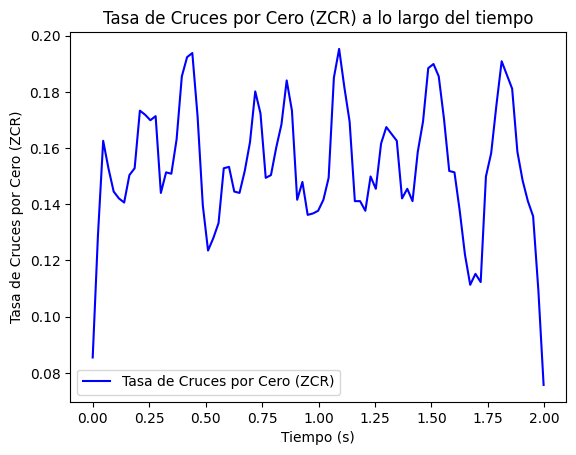

In [117]:
# Calcular la magnitud y la fase de la transformada de Fourier de corto tiempo (STFT)
S, phase = librosa.magphase(librosa.stft(x))

# Calcular la tasa de cruces por cero (ZCR)
zcr = librosa.feature.zero_crossing_rate(x)

# Crear el gráfico
fig, ax = plt.subplots(nrows=1)
times = librosa.times_like(zcr)
ax.plot(times, zcr[0], label='Tasa de Cruces por Cero (ZCR)', color='b')
ax.legend()
ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('Tasa de Cruces por Cero (ZCR)')
ax.set_title('Tasa de Cruces por Cero (ZCR) a lo largo del tiempo')
plt.show()

## spectral centroid (centroide espectral)

El centroide espectral es una medida que indica el "centro de masa" de la distribución de energía espectral de una señal de audio. En términos más simples, representa el promedio ponderado de las frecuencias presentes en la señal, donde las frecuencias más altas tienen un peso menor que las frecuencias más bajas.

El centroide espectral proporciona información sobre la "tonalidad" percibida de una señal de audio. Las señales con un centroide espectral más alto tienden a sonar más agudas, mientras que las señales con un centroide espectral más bajo tienden a sonar más graves. Esta característica puede ser útil para el análisis y la clasificación de sonidos en aplicaciones de procesamiento de audio y música.

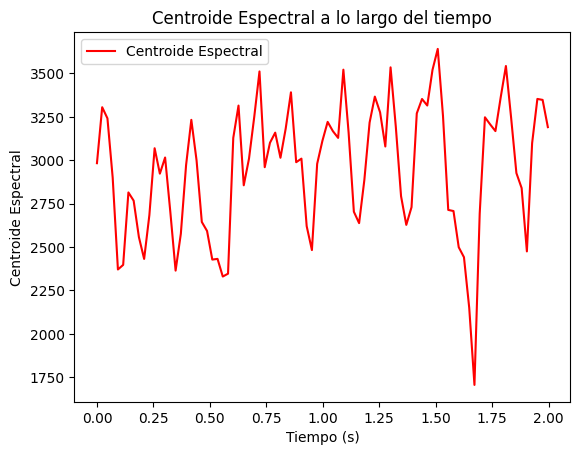

In [118]:


# Calcular el centroide espectral
spec_cent = librosa.feature.spectral_centroid(y=x, sr=sr)

# Crear el gráfico
fig, ax = plt.subplots(nrows=1)
times = librosa.times_like(spec_cent)
ax.plot(times, spec_cent[0], label='Centroide Espectral', color='r')
ax.legend()
ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('Centroide Espectral')
ax.set_title('Centroide Espectral a lo largo del tiempo')
plt.show()

## spectral bandwidth (anchura espectral)

es una medida que describe la extensión de las frecuencias presentes en una señal de audio. En términos generales, representa la amplitud del rango de frecuencias en la señal.

En el contexto del procesamiento de señales de audio, la anchura espectral se calcula a partir de la distribución de energía espectral de la señal. Esta medida proporciona información sobre la dispersión de las frecuencias presentes en la señal, lo que puede ser útil para caracterizar su contenido espectral.

En resumen, la anchura espectral es una medida que describe la distribución de las frecuencias presentes en una señal de audio, proporcionando información sobre su contenido espectral y su dispersión en el dominio de las frecuencias.



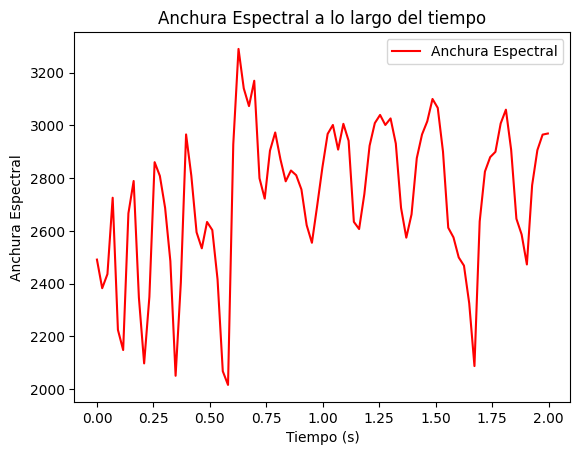

In [119]:
# Calcular la anchura espectral
spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=sr)

# Crear el gráfico
fig, ax = plt.subplots(nrows=1)
times = librosa.times_like(spec_bw)
ax.plot(times, spec_bw[0], label='Anchura Espectral', color='r')
ax.legend()
ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('Anchura Espectral')
ax.set_title('Anchura Espectral a lo largo del tiempo')
plt.show()

##  chroma_stft


El chroma_stft es una representación de características musicales que se utiliza comúnmente en el análisis de audio y la música. Se calcula a partir de la transformada de Fourier de corto tiempo (STFT) de una señal de audio, que es una representación en el dominio de la frecuencia-tiempo de la señal. El chroma_stft se utiliza para capturar la información tonal y armónica de la música, ignorando la información sobre el timbre y el volumen.

Para calcular el chroma_stft, primero se divide la señal de audio en segmentos pequeños, llamados tramas, y se aplica la STFT a cada trama para obtener una representación de dominio de frecuencia. Luego, se calcula el espectro de potencia de cada trama y se agrupa la energía en función de las clases de notas musicales, como C, C#, D, etc., ignorando la octava a la que pertenecen. Esto resulta en un vector de 12 elementos que representa la energía de cada clase de nota en cada trama.

El chroma_stft es útil para capturar la progresión armónica y la relación tonal en la música, ya que las notas musicales relacionadas armónicamente tendrán valores de chroma_stft similares. Es una representación compacta que se utiliza en tareas como la transcripción automática de música, la clasificación de género musical y el análisis de acordes.

En resumen, el chroma_stft es una representación de características musicales que se utiliza para capturar la información tonal y armónica de la música a partir de su representación en el dominio de la frecuencia-tiempo.


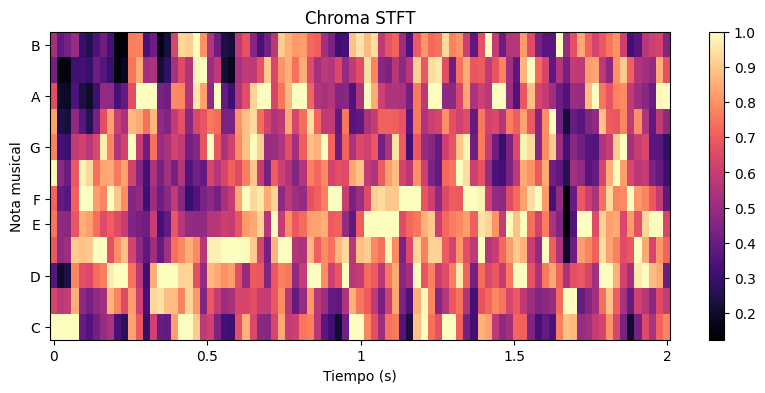

In [120]:
# Calcular el chroma_stft
chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr)

# Crear el gráfico
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma STFT')
plt.ylabel('Nota musical')
plt.xlabel('Tiempo (s)')
plt.show()

## spectral_rolloff

El spectral_rolloff es una medida que se utiliza en el análisis de señales de audio para caracterizar la forma en que disminuye la energía espectral a medida que aumenta la frecuencia. En otras palabras, el spectral_rolloff indica la frecuencia por debajo de la cual se encuentra un porcentaje específico de la energía espectral total.

Matemáticamente, el spectral_rolloff se calcula de la siguiente manera:

Se calcula la magnitud de la transformada de Fourier de corto tiempo (STFT) de la señal de audio. Esta transformada divide la señal de audio en pequeñas ventanas de tiempo y calcula la transformada de Fourier para cada ventana.

Para cada ventana de la STFT, se ordenan las frecuencias en función de su magnitud, de menor a mayor.

Se suma la magnitud de todas las frecuencias para obtener la energía espectral total.

Se calcula un porcentaje (generalmente un valor entre 85% y 95%) de la energía espectral total.

Se recorre la lista ordenada de frecuencias y se suma la magnitud de las frecuencias hasta alcanzar el porcentaje deseado de la energía total. La frecuencia en la que se alcanza este porcentaje se toma como el spectral_rolloff.

El spectral_rolloff es útil en aplicaciones de procesamiento de señales de audio, como el reconocimiento de sonido y la música, ya que proporciona información sobre la distribución de la energía espectral en la señal. Por ejemplo, un spectral_rolloff más bajo puede indicar una señal con componentes de frecuencia más bajos y un timbre más grave, mientras que un spectral_rolloff más alto puede indicar una señal con componentes de frecuencia más altos y un timbre más agudo.


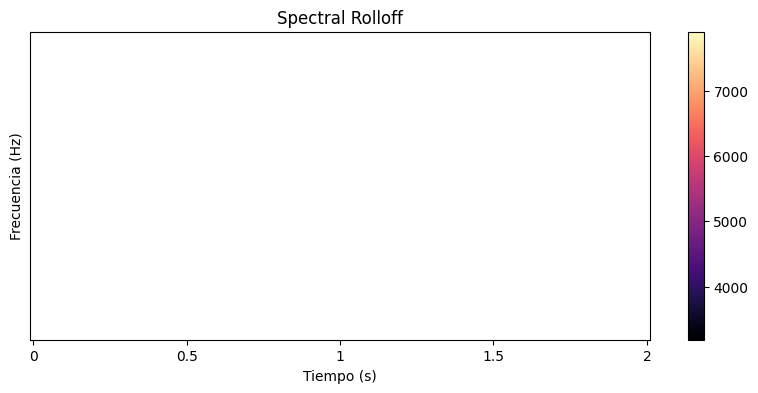

In [121]:

# Calcular el spectral_rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)

# Crear el gráfico
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectral_rolloff, x_axis='time', sr=sr, hop_length=512)
plt.colorbar()
plt.title('Spectral Rolloff')
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.show()

## mfcc


Los coeficientes cepstrales en frecuencia Mel (MFCC, por sus siglas en inglés) son un conjunto de características ampliamente utilizadas en el procesamiento de señales de voz y audio para representar las características espectrales de una señal de audio de manera compacta y efectiva.

El cálculo de los MFCC implica varios pasos:

Pre-énfasis: Se aplica un filtro de pre-énfasis a la señal de audio para aumentar la energía de las frecuencias altas. Esto ayuda a mejorar la relación señal-ruido y a suavizar la transición entre las frecuencias.

Framing: La señal de audio se divide en pequeños segmentos llamados tramas, que suelen tener una duración de 20-40 milisegundos. Esto se hace para asumir que la señal es estacionaria dentro de cada trama.

Ventaneo: Cada trama se multiplica por una ventana, típicamente una ventana de Hamming, para reducir las discontinuidades en los bordes de la trama.

Transformada de Fourier de corto tiempo (STFT): Se calcula la STFT de cada trama, que consiste en calcular la magnitud de la transformada de Fourier para segmentos superpuestos de la señal.

Filtrado en escala Mel: Se aplica un banco de filtros en escala Mel a la salida de la STFT para calcular la energía en diferentes bandas de frecuencia Mel. La escala Mel es una escala no lineal que simula de manera más precisa la percepción humana de la frecuencia.

Logaritmo: Se aplica el logaritmo a las energías calculadas para cada filtro.

Transformada de coseno discreta (DCT): Finalmente, se aplica la DCT a los logaritmos de las energías para obtener los coeficientes cepstrales en frecuencia Mel. La DCT es similar a la transformada de Fourier, pero se utiliza para señales que son consideradas como secuencias finitas en lugar de señales periódicas.

Los MFCC resultantes son una representación compacta de las características espectrales de la señal de audio, que capturan información relevante para tareas como reconocimiento del habla, identificación de locutores y procesamiento de música. Los primeros coeficientes MFCC suelen contener la mayor parte de la información relevante, mientras que los coeficientes posteriores pueden contener información más específica sobre la forma de onda.

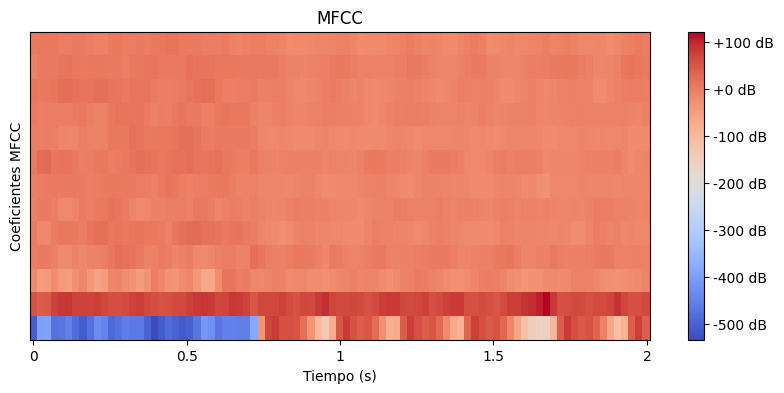

In [122]:
# Calcular los coeficientes MFCC
mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)  # Utilizamos 13 coeficientes MFCC por defecto

# Visualizar los coeficientes MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Tiempo (s)')
plt.ylabel('Coeficientes MFCC')
plt.show()


# En este código, estamos cargando un archivo de audio usando librosa.load.
# Luego, calculamos los coeficientes MFCC utilizando librosa.feature.mfcc.
# Estos coeficientes se visualizan utilizando librosa.display.specshow,
# que es una función de librosa para mostrar espectrogramas y otras representaciones espectrales.
# El eje x representa el tiempo y el eje y representa los coeficientes MFCC.
# La barra de color a la derecha muestra la escala de colores asociada a los valores de los coeficientes MFCC.


****************************************************************************************************************************************************************
## Extracción de características a todos los audios
****************************************************************************************************************************************************************

Extraemos las siete características antes vistas para cada audio y luego calculamos el promedio, el desvio estándar y la media, lo que nos permite realizar una visualización rápida para un análisis exploratorio

###Cálculo de promédios:

In [123]:
def extract_features_mean(file_path):

        # Cargar el archivo de audio
        y, sr = librosa.load(file_path, sr=None)


        rms = np.mean(librosa.feature.rms(y=y))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr))


        # Combinar todas las características en un vector de características
        features = [rms, zcr, spec_cent, spec_bw, chroma_stft, rolloff, mfcc]
        # features = np.concatenate(( [rms, zcr, spec_cent, spec_bw], mfccs_mean, mfccs_std))

        return features


In [124]:
data_mean = []

for i, carpeta in enumerate(carpetas):
    # Obtener el nombre de la clase a partir del nombre de la carpeta
    clase = os.path.basename(carpeta)

    # Recorrer los archivos de la carpeta
    for filename in os.listdir(carpeta):
        file_path1 = os.path.join(carpeta, filename)

        # Extraer características y agregarlas al DataFrame junto con el "target"
        features = extract_features_mean(file_path1)
        if features is not None:
            # Agregar las nuevas características a la lista de features
            data_mean.append([*features, i, clase])

# Crear un DataFrame con los datos y asignar nombres a las columnas
column_names =  ['rms', 'zcr', 'spec_cent', 'spec_bw', 'chroma_stft', 'rolloff', 'mfcc','target', 'class']
# column_names =  ['rms', 'zcr', 'spec_cent', 'spec_bw'] + [f'mfcc_{i}' for i in range(24)] + [f'mfcc_std_{i}' for i in range(24)] + ['target', 'class']
df_mean = pd.DataFrame(data_mean, columns=column_names)


In [125]:
df_mean

,rms,zcr,spec_cent,spec_bw,chroma_stft,rolloff,mfcc,target,class
0,0.129963,0.094202,3621.934311,3610.109209,0.587258,7485.837586,-6.336405,0,AK-12
1,0.139891,0.094851,3664.929185,3686.122423,0.621656,7740.999819,-3.821254,0,AK-12
2,0.101817,0.087766,3479.817190,3584.183697,0.608300,7217.481598,-5.862502,0,AK-12
3,0.100538,0.090293,3499.550478,3572.589392,0.601800,7287.184452,-5.721093,0,AK-12
4,0.114754,0.081216,3272.619743,3459.847351,0.613220,6802.749616,-5.562001,0,AK-12
...,...,...,...,...,...,...,...,...,...
846,0.315827,0.078355,3421.437747,3742.497160,0.655211,7543.056304,6.113061,8,Zastava M92
847,0.120748,0.077755,2899.145218,3123.723111,0.689577,5914.909513,-0.597770,8,Zastava M92
848,0.226197,0.067959,3007.369984,3450.639035,0.657410,6564.390749,2.552109,8,Zastava M92
849,0.301605,0.078086,3430.965482,3808.745706,0.648921,7722.994679,5.064621,8,Zastava M92


## Análisis de correlación:
Al calcular la matriz de correlación entre las diferentes características podemos ver si alguna de ellas está altamente correlacionada. Esto podría indicar que algunas características podrían no ser necesarias o redundantes para el análisis.
Posteriormente realizamos un entrenamiento básico para comprobar el rendimiento del modelo.

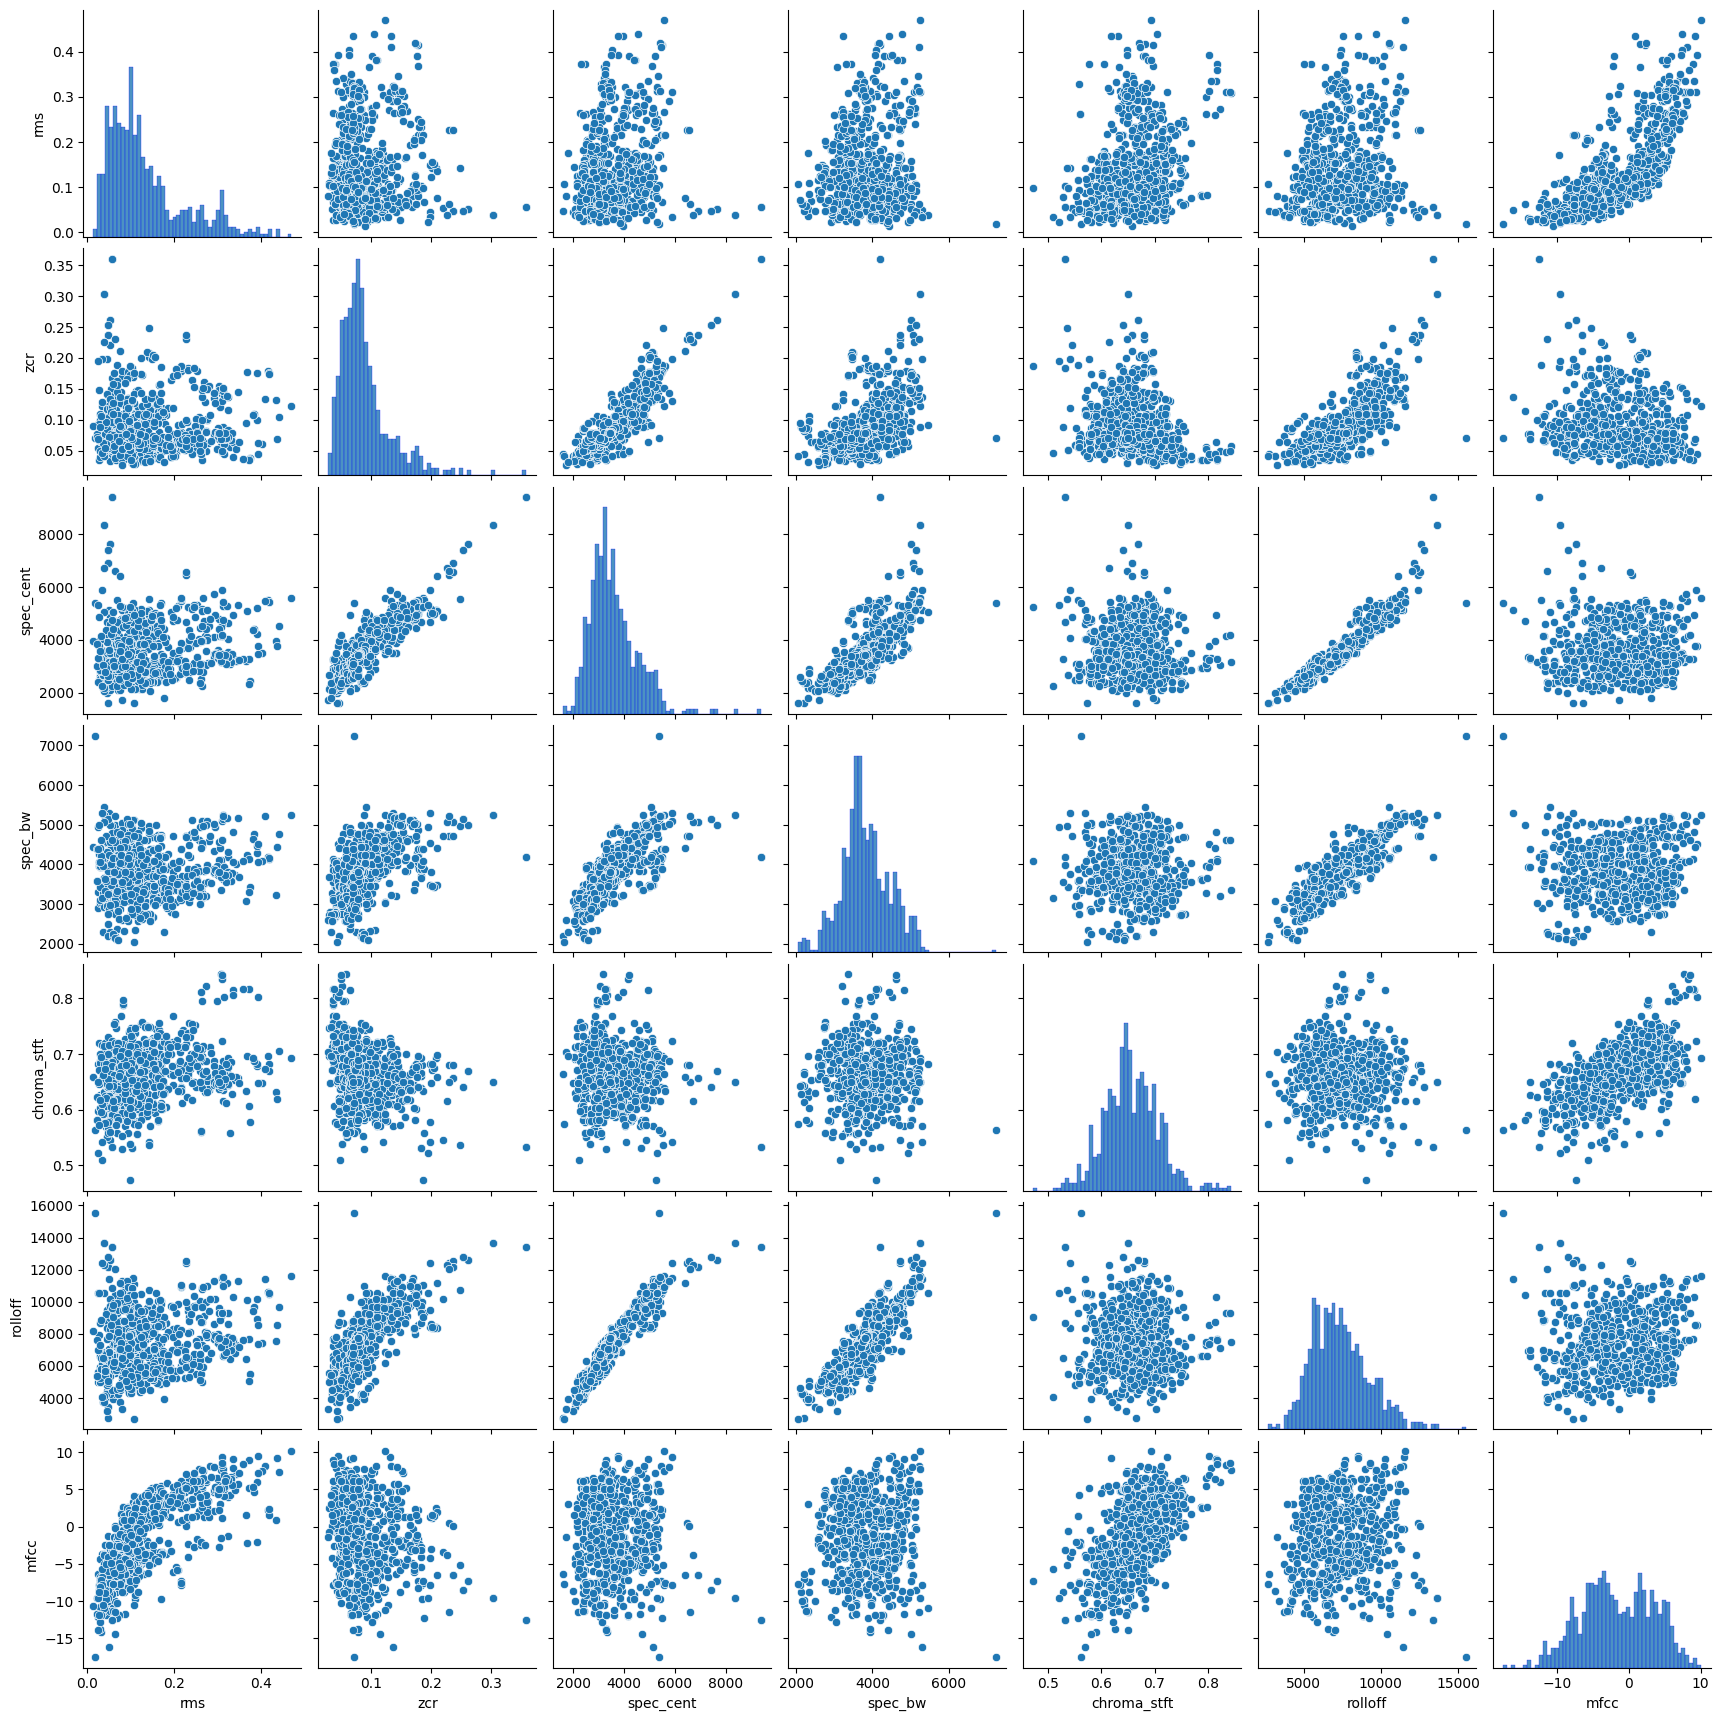

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar las columnas que no quieres mostrar en los histogramas diagonales
columns_to_plot = ['rms', 'zcr', 'spec_cent', 'spec_bw', 'chroma_stft', 'rolloff', 'mfcc']

# Obtener un DataFrame con las columnas seleccionadas
df_selected = df_mean[columns_to_plot]

# Establecer el número de bins y otros parámetros para los histogramas
hist_kws = {'alpha': 0.8, 'edgecolor': 'blue', 'linewidth': 0.2, 'bins': 50}

# Crear pairplot con ajustes personalizados para los histogramas
sns.pairplot(df_selected, diag_kws=hist_kws)
plt.show()


In [127]:
from sklearn.model_selection import train_test_split

# Dividir los datos en características (X) y etiquetas (y)
X = df_mean.iloc[:, :-2]  # Todas las columnas menos las dos últimas
y = df_mean['target']  # La columna "target" como etiqueta

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Crear un modelo SVM con un kernel lineal
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

# Entrenar el modelo SVM
svm_model.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo SVM: {accuracy:.2f}')

Precisión del modelo SVM: 0.54


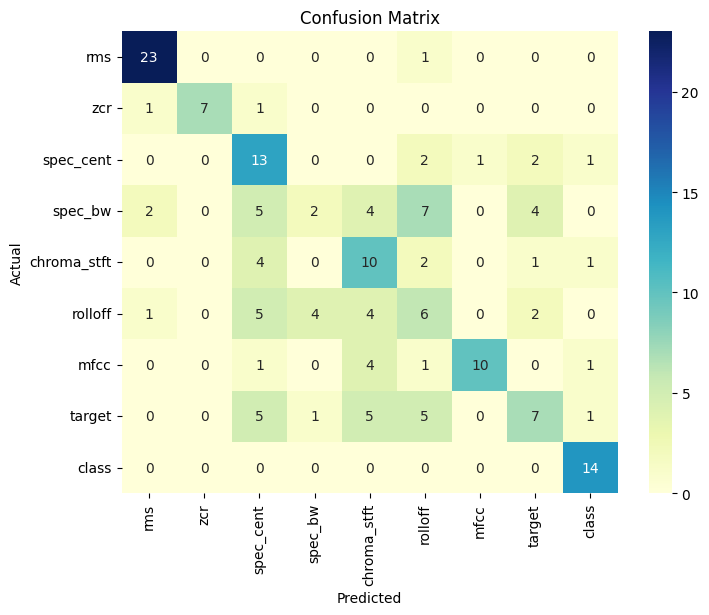

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir las etiquetas de las clases
labels = column_names

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Cálculo de desviación estándar

Calculamos la desviación estándar, luego visualizamos los datos para después realizar un entrenamiento básico y comprobar el rendimiento del modelo.

In [130]:
def extract_features_std(file_path):

        # Cargar el archivo de audio
        y, sr = librosa.load(file_path, sr=None)


        rms = np.std(librosa.feature.rms(y=y))
        zcr = np.std(librosa.feature.zero_crossing_rate(y))
        spec_cent = np.std(librosa.feature.spectral_centroid(y=y, sr=sr))
        spec_bw = np.std(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        chroma_stft = np.std(librosa.feature.chroma_stft(y=y, sr=sr))
        rolloff = np.std(librosa.feature.spectral_rolloff(y=y, sr=sr))
        mfcc = np.std(librosa.feature.mfcc(y=y, sr=sr))


        # Combinar todas las características en un vector de características
        features = [rms, zcr, spec_cent, spec_bw, chroma_stft, rolloff, mfcc]
        # features = np.concatenate(( [rms, zcr, spec_cent, spec_bw], mfccs_mean, mfccs_std))

        return features

In [131]:
data_std = []

for i, carpeta in enumerate(carpetas):
    # Obtener el nombre de la clase a partir del nombre de la carpeta
    clase = os.path.basename(carpeta)

    # Recorrer los archivos de la carpeta
    for filename in os.listdir(carpeta):
        file_path1 = os.path.join(carpeta, filename)

        # Extraer características y agregarlas al DataFrame junto con el "target"
        features = extract_features_std(file_path1)
        if features is not None:
            # Agregar las nuevas características a la lista de features
            data_std.append([*features, i, clase])

# Crear un DataFrame con los datos y asignar nombres a las columnas
column_names =  ['rms', 'zcr', 'spec_cent', 'spec_bw', 'chroma_stft', 'rolloff', 'mfcc','target', 'class']
# column_names =  ['rms', 'zcr', 'spec_cent', 'spec_bw'] + [f'mfcc_{i}' for i in range(24)] + [f'mfcc_std_{i}' for i in range(24)] + ['target', 'class']
df_std = pd.DataFrame(data_std, columns=column_names)

In [132]:
df_std

,rms,zcr,spec_cent,spec_bw,chroma_stft,rolloff,mfcc,target,class
0,0.105367,0.034661,1228.868257,705.699673,0.234839,2769.696737,57.862213,0,AK-12
1,0.099878,0.027132,975.039058,520.671017,0.221957,1994.560415,51.245510,0,AK-12
2,0.099443,0.033807,1270.817937,654.462039,0.233163,2769.504965,60.263329,0,AK-12
3,0.096143,0.031372,1168.996431,624.834149,0.227887,2544.088923,58.169498,0,AK-12
4,0.105390,0.030747,1183.580936,707.401492,0.225092,2781.771979,60.477631,0,AK-12
...,...,...,...,...,...,...,...,...,...
846,0.066149,0.020054,568.931050,298.522586,0.205104,1270.356684,41.583290,8,Zastava M92
847,0.084498,0.023492,667.666826,371.060306,0.194821,1365.914864,50.758049,8,Zastava M92
848,0.125198,0.012186,536.028915,467.642923,0.209810,1506.153834,47.430077,8,Zastava M92
849,0.081943,0.014344,437.335937,265.892340,0.192349,1030.473675,42.330242,8,Zastava M92


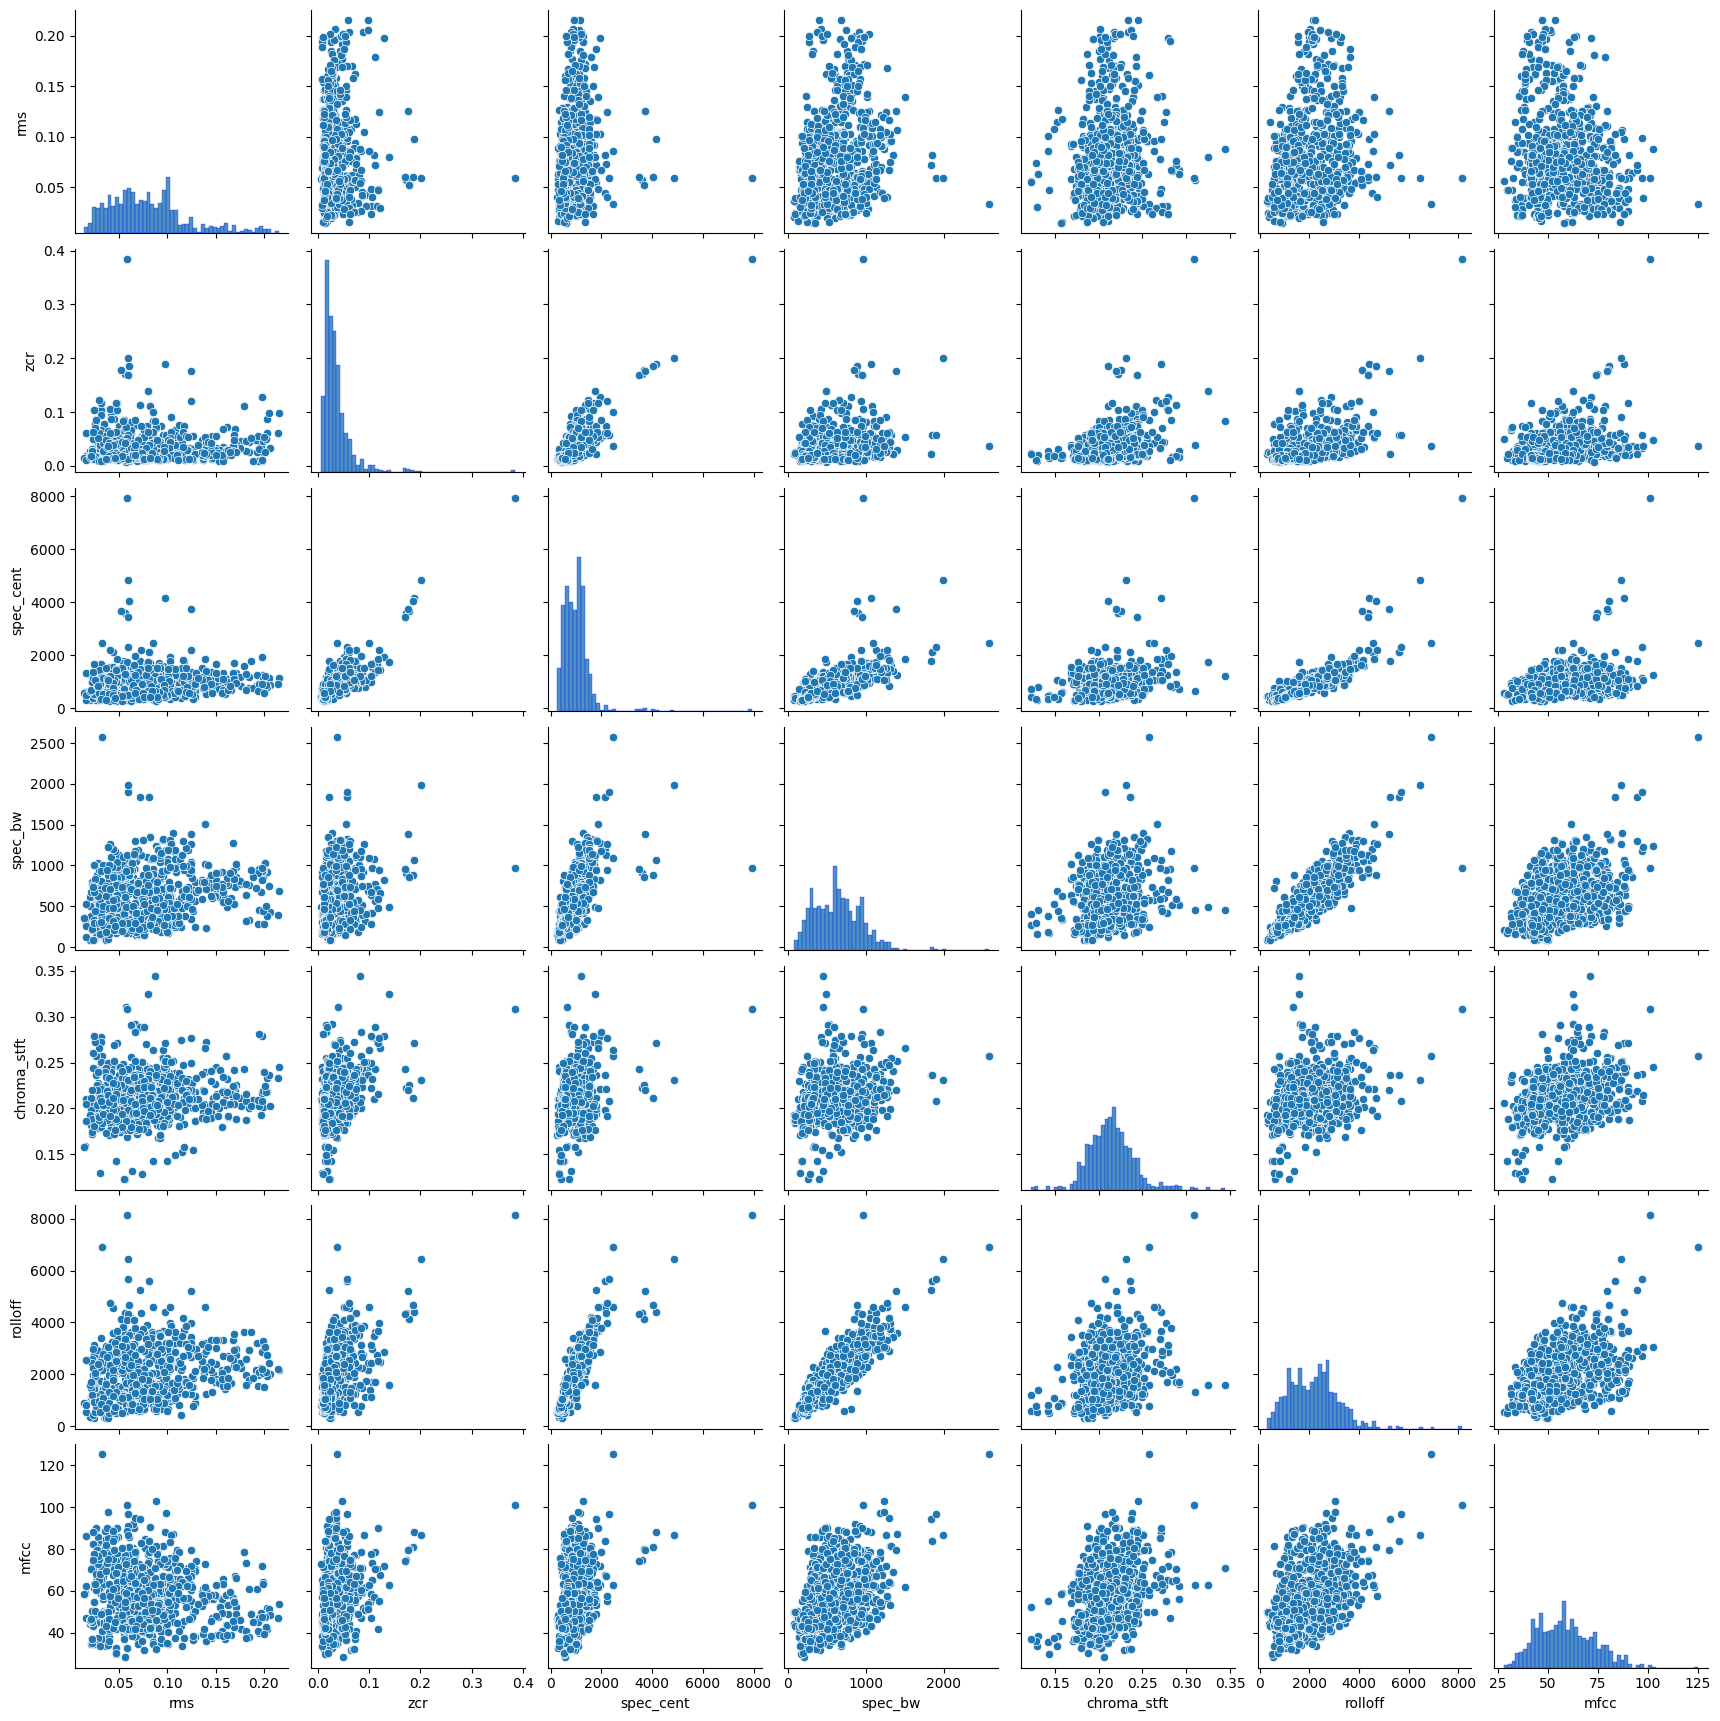

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar las columnas que no quieres mostrar en los histogramas diagonales
columns_to_plot = ['rms', 'zcr', 'spec_cent', 'spec_bw', 'chroma_stft', 'rolloff', 'mfcc']

# Obtener un DataFrame con las columnas seleccionadas
df_selected = df_std[columns_to_plot]

# Establecer el número de bins y otros parámetros para los histogramas
hist_kws = {'alpha': 0.8, 'edgecolor': 'blue', 'linewidth': 0.2, 'bins': 50}

# Crear pairplot con ajustes personalizados para los histogramas
sns.pairplot(df_selected, diag_kws=hist_kws)
plt.show()

In [134]:
from sklearn.model_selection import train_test_split

# Dividir los datos en características (X) y etiquetas (y)
X = df_std.iloc[:, :-2]  # Todas las columnas menos las dos últimas
y = df_std['target']  # La columna "target" como etiqueta

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Crear un modelo SVM con un kernel lineal
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

# Entrenar el modelo SVM
svm_model.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo SVM: {accuracy:.2f}')

Precisión del modelo SVM: 0.51


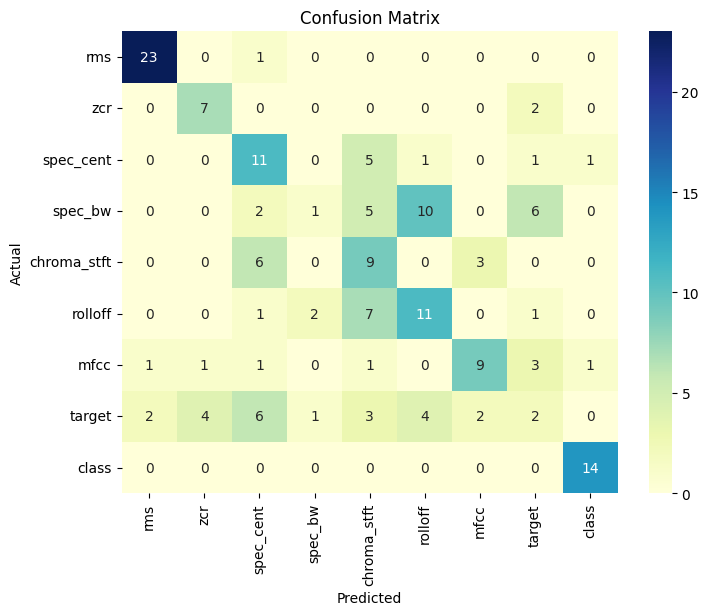

In [136]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir las etiquetas de las clases
labels = column_names

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Mediana

In [137]:
def extract_features_median(file_path):
    # Cargar el archivo de audio
    y, sr = librosa.load(file_path, sr=None)

    # Calcular la mediana de las características
    rms = np.median(librosa.feature.rms(y=y))
    zcr = np.median(librosa.feature.zero_crossing_rate(y))
    spec_cent = np.median(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw = np.median(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    chroma_stft = np.median(librosa.feature.chroma_stft(y=y, sr=sr))
    rolloff = np.median(librosa.feature.spectral_rolloff(y=y, sr=sr))
    mfcc = np.median(librosa.feature.mfcc(y=y, sr=sr))

    # Combinar todas las características en un vector de características
    features = [rms, zcr, spec_cent, spec_bw, chroma_stft, rolloff, mfcc]

    return features

In [138]:
data_median = []

for i, carpeta in enumerate(carpetas):
    # Obtener el nombre de la clase a partir del nombre de la carpeta
    clase = os.path.basename(carpeta)

    # Recorrer los archivos de la carpeta
    for filename in os.listdir(carpeta):
        file_path1 = os.path.join(carpeta, filename)

        # Extraer características y agregarlas al DataFrame junto con el "target"
        features = extract_features_median(file_path1)
        if features is not None:
            # Agregar las nuevas características a la lista de features
            data_median.append([*features, i, clase])

# Crear un DataFrame con los datos y asignar nombres a las columnas
column_names =  ['rms', 'zcr', 'spec_cent', 'spec_bw', 'chroma_stft', 'rolloff', 'mfcc','target', 'class']
# column_names =  ['rms', 'zcr', 'spec_cent', 'spec_bw'] + [f'mfcc_{i}' for i in range(24)] + [f'mfcc_std_{i}' for i in range(24)] + ['target', 'class']
df_median = pd.DataFrame(data_median, columns=column_names)

In [139]:
df_median

,rms,zcr,spec_cent,spec_bw,chroma_stft,rolloff,mfcc,target,class
0,0.092162,0.094238,3719.779284,3762.673600,0.567592,8031.884766,-4.733171,0,AK-12
1,0.107301,0.095703,3700.504891,3827.756467,0.602028,7708.886719,-4.935033,0,AK-12
2,0.050925,0.077148,3157.158140,3538.332957,0.591465,6933.691406,-3.769619,0,AK-12
3,0.053537,0.082031,3157.793706,3507.366648,0.582575,7149.023438,-4.085999,0,AK-12
4,0.056930,0.075195,3082.128799,3473.256199,0.593377,7084.423828,-4.111211,0,AK-12
...,...,...,...,...,...,...,...,...,...
846,0.329611,0.082520,3566.879329,3808.927655,0.643264,7967.285156,-2.206172,8,Zastava M92
847,0.087808,0.077148,2848.069685,3151.308348,0.684296,5964.697266,-1.332796,8,Zastava M92
848,0.239550,0.066406,2961.799194,3486.986012,0.653219,6459.960938,-2.833411,8,Zastava M92
849,0.308920,0.077148,3481.964760,3837.776797,0.624250,7902.685547,-2.663849,8,Zastava M92


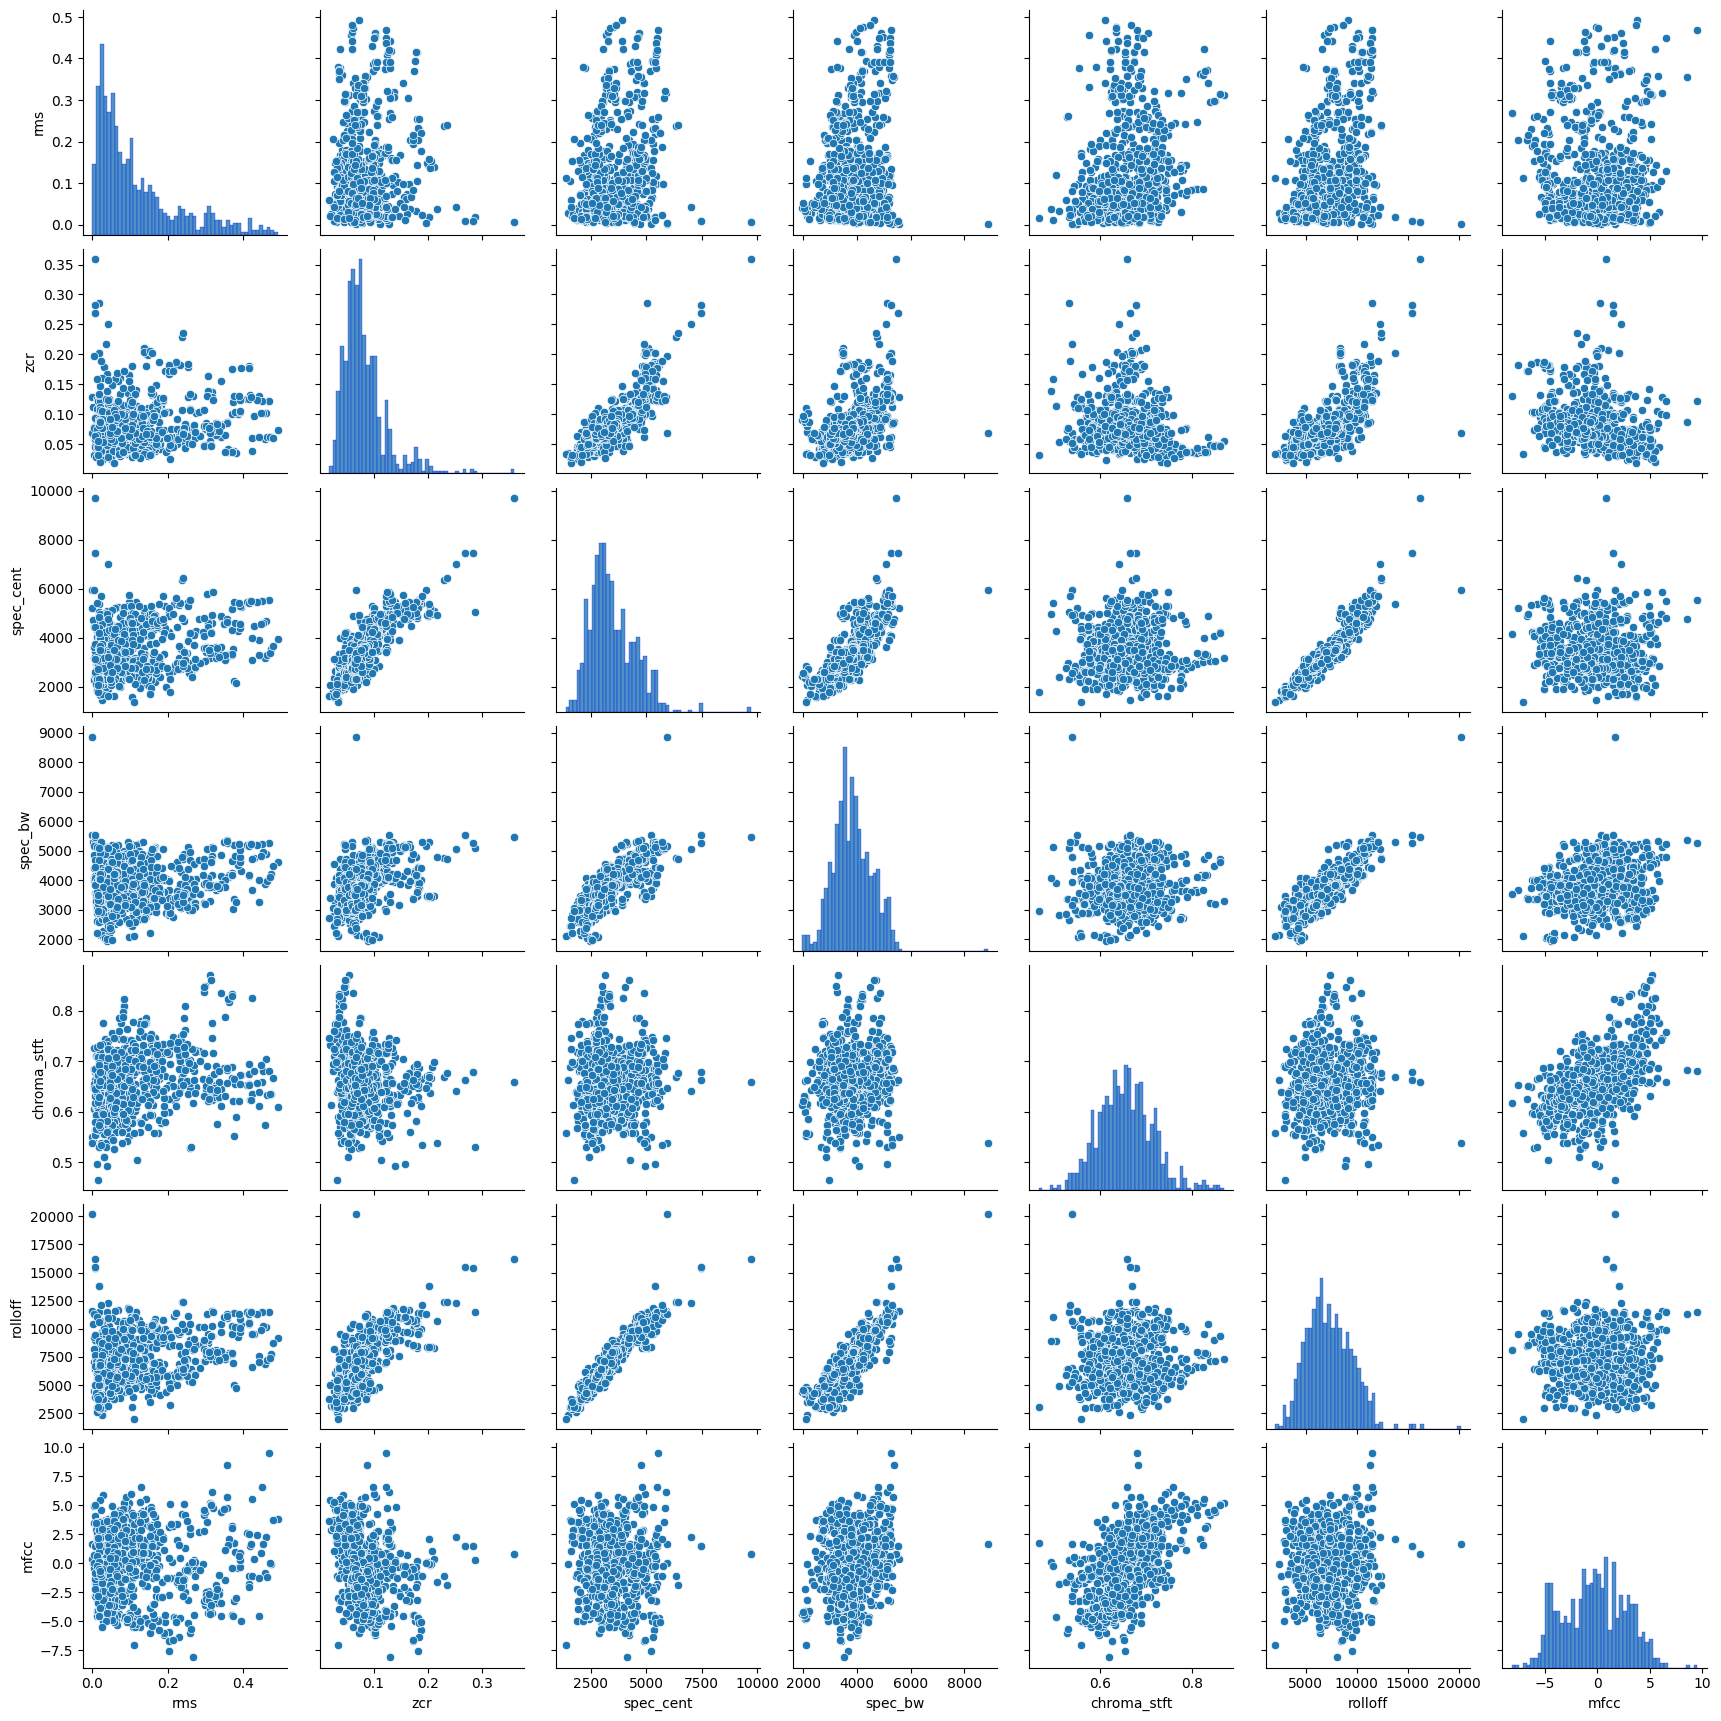

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar las columnas que no quieres mostrar en los histogramas diagonales
columns_to_plot = ['rms', 'zcr', 'spec_cent', 'spec_bw', 'chroma_stft', 'rolloff', 'mfcc']

# Obtener un DataFrame con las columnas seleccionadas
df_selected = df_median[columns_to_plot]

# Establecer el número de bins y otros parámetros para los histogramas
hist_kws = {'alpha': 0.8, 'edgecolor': 'blue', 'linewidth': 0.2, 'bins': 50}

# Crear pairplot con ajustes personalizados para los histogramas
sns.pairplot(df_selected, diag_kws=hist_kws)
plt.show()

In [141]:
from sklearn.model_selection import train_test_split

# Dividir los datos en características (X) y etiquetas (y)
X = df_median.iloc[:, :-2]  # Todas las columnas menos las dos últimas
y = df_median['target']  # La columna "target" como etiqueta

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Crear un modelo SVM con un kernel lineal
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

# Entrenar el modelo SVM
svm_model.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo SVM: {accuracy:.2f}')

Precisión del modelo SVM: 0.51


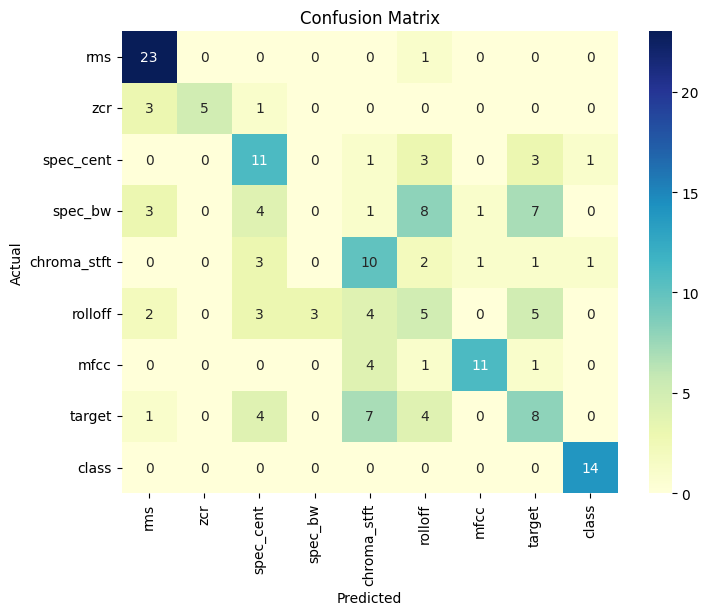

In [143]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir las etiquetas de las clases
labels = column_names

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

****************************************************************************************************************************************************************
Podemos apreciar que al calcular los promedios obtenemos resultados ligeramente superiores a la desviación estándar y a la mediana.
****************************************************************************************************************************************************************

****************************************************************************************************************************************************************
## Ensamble final:
****************************************************************************************************************************************************************


El parámetro n_chroma en la función librosa.feature.chroma_stft es un parámetro que controla el número de coeficientes de croma que se calculan. El croma es una representación de la distribución de energía tonal en un fragmento de audio y se calcula utilizando la Transformada de Fourier a corto plazo (STFT) del audio.

El parámetro n_chroma especifica el número de bins en los que se divide el espacio de frecuencia para calcular el croma. Un valor más alto de n_chroma resultará en una representación más detallada del croma, con más información sobre la distribución tonal en diferentes regiones del espectro de frecuencia.

En el contexto de la función librosa.feature.chroma_stft, el parámetro n_chroma=24 significa que se calcularán 24 coeficientes de croma. Estos coeficientes representarán la distribución de la energía tonal en 24 bins o segmentos del espectro de frecuencia, proporcionando una representación más detallada del croma en comparación con un número menor de coeficientes.

En resumen, n_chroma controla la resolución o granularidad de la representación del croma en la función librosa.feature.chroma_stft, donde un valor más alto de n_chroma proporciona una representación más detallada pero también puede requerir más recursos computacionales.

El parámetro n_mfcc en la función librosa.feature.mfcc es un parámetro que controla el número de coeficientes cepstrales de frecuencia mel (MFCC) que se calcularán. Los coeficientes MFCC son características ampliamente utilizadas en el procesamiento de señales de audio para representar de manera compacta la información relevante para el reconocimiento del habla y otros tipos de análisis de audio.

Cuando se establece n_mfcc=24, significa que se calcularán 24 coeficientes MFCC a partir de la señal de audio y con una tasa de muestreo sr. Estos coeficientes representarán aspectos importantes del espectro de frecuencia del audio, capturando información sobre la distribución de energía en diferentes bandas de frecuencia y cómo estas bandas se relacionan con la percepción auditiva humana.

El uso de 24 coeficientes MFCC es común en muchas aplicaciones de procesamiento de señales de audio y reconocimiento del habla. Este número se ha encontrado empíricamente para capturar adecuadamente la información relevante para muchas tareas de análisis de audio, aunque en algunos casos se pueden usar más o menos coeficientes dependiendo de la aplicación específica y la naturaleza de los datos de audio.

En resumen, n_mfcc controla la cantidad de información capturada por los coeficientes MFCC en la función librosa.feature.mfcc, donde un valor más alto de n_mfcc puede capturar más detalles pero también puede aumentar la dimensionalidad de los datos resultantes y requerir más recursos computacionales.

In [190]:
def extract_features(file_path):
    try:
        # Cargar el archivo de audio
        y, sr = librosa.load(file_path, sr=None)

        # Calcular diferentes características de interés


        chroma_stft = librosa.feature.chroma_stft( y=y, sr=sr, n_chroma=24)
        chroma_stft_mean = np.mean(chroma_stft, axis=1)
        chroma_stft_std = np.std(chroma_stft, axis=1)

        #le damos importancia al rms ya que mostró buenos valores en los graficos anteriores
        rms = np.mean(librosa.feature.rms(y=y))
        rms_std = np.std(librosa.feature.rms(y=y))

        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

        # Extraer características de los coeficientes MFCC


        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=24)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)

        # Aplanar las características que tienen más de una dimensión
        # chroma_stft_flat = chroma_stft.ravel()

        # Combinar todas las características en un vector de características
        features = np.concatenate(( chroma_stft_mean, chroma_stft_std, [rms, rms_std, zcr, spec_cent, spec_bw], mfccs_mean, mfccs_std))
        # features = np.concatenate(( [rms, zcr, spec_cent, spec_bw], mfccs_mean, mfccs_std))

        return features

    except Exception as e:
        print("Error encountered while parsing file:", file_path)
        return None

In [191]:
data = []

for i, carpeta in enumerate(carpetas):
    # Obtener el nombre de la clase a partir del nombre de la carpeta
    clase = os.path.basename(carpeta)

    # Recorrer los archivos de la carpeta
    for filename in os.listdir(carpeta):
        file_path = os.path.join(carpeta, filename)

        # Extraer características y agregarlas al DataFrame junto con el "target"
        features = extract_features(file_path)
        if features is not None:
            # Agregar las nuevas características a la lista de features
            data.append([*features, i, clase])

# Crear un DataFrame con los datos y asignar nombres a las columnas
column_names = [f'chroma_stft_m{i}' for i in range(24)] + [f'chroma_stft_s{i}' for i in range(24)] + ['rms', 'rms_std', 'zcr', 'spec_cent', 'spec_bw'] +  [f'mfcc_{i}' for i in range(24)] + [f'mfcc_std_{i}' for i in range(24)] + ['target', 'class']
# column_names =  ['rms', 'zcr', 'spec_cent', 'spec_bw'] + [f'mfcc_{i}' for i in range(24)] + [f'mfcc_std_{i}' for i in range(24)] + ['target', 'class']
df = pd.DataFrame(data, columns=column_names)

In [192]:
df

,chroma_stft_m0,chroma_stft_m1,chroma_stft_m2,chroma_stft_m3,chroma_stft_m4,chroma_stft_m5,chroma_stft_m6,chroma_stft_m7,chroma_stft_m8,chroma_stft_m9,...,mfcc_std_16,mfcc_std_17,mfcc_std_18,mfcc_std_19,mfcc_std_20,mfcc_std_21,mfcc_std_22,mfcc_std_23,target,class
0,0.502874,0.515142,0.500999,0.504403,0.495619,0.534467,0.556789,0.557611,0.539193,0.533429,...,6.961073,6.614680,6.518144,4.998499,7.343331,4.118984,6.551759,4.637143,0,AK-12
1,0.545794,0.582134,0.583765,0.554665,0.546340,0.595571,0.600958,0.597913,0.588915,0.576348,...,5.793761,5.287525,5.709456,4.775393,5.788785,4.747897,5.564710,3.958461,0,AK-12
2,0.547372,0.552682,0.589376,0.599358,0.554395,0.552262,0.552827,0.547273,0.552855,0.544665,...,5.578058,5.888566,6.600759,5.224847,5.881674,4.757607,6.961311,4.474829,0,AK-12
3,0.533061,0.541987,0.537519,0.560170,0.582547,0.545171,0.548789,0.542019,0.547204,0.559006,...,5.860741,6.281090,7.192839,5.411286,6.311194,4.844716,7.174056,4.820223,0,AK-12
4,0.543862,0.547732,0.569135,0.589818,0.606786,0.577287,0.569330,0.582314,0.570481,0.548613,...,5.631896,5.160222,5.751182,5.355292,6.371185,4.491196,6.453117,3.989816,0,AK-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,0.563334,0.571414,0.593550,0.580388,0.607564,0.567835,0.537455,0.567576,0.598457,0.605942,...,3.574952,3.719423,4.623709,3.986797,3.784564,4.144530,3.911114,4.313366,8,Zastava M92
847,0.619155,0.643723,0.632923,0.627789,0.624087,0.638189,0.637051,0.637399,0.686468,0.727095,...,5.186637,4.266609,4.776217,5.086032,5.284681,4.641883,4.332790,4.144189,8,Zastava M92
848,0.620939,0.672188,0.717353,0.728572,0.704100,0.713047,0.684161,0.656668,0.664836,0.649270,...,4.602473,5.091374,4.398983,5.421748,5.157950,4.839213,5.256199,5.131216,8,Zastava M92
849,0.573471,0.565190,0.573683,0.590053,0.589915,0.585722,0.555596,0.572173,0.572547,0.555728,...,3.690807,4.029222,4.553047,3.909809,4.597289,3.774198,3.039274,4.211092,8,Zastava M92


In [193]:
from sklearn.model_selection import train_test_split

# Dividir los datos en características (X) y etiquetas (y)
X = df.iloc[:, :-2]  # Todas las columnas menos las dos últimas
y = df['target']  # La columna "target" como etiqueta

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo SVM con un kernel RBF y regularización C=1.0
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1))

# Entrenar el modelo SVM
svm_model.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo SVM: {accuracy:.2f}')

Precisión del modelo SVM: 0.74


## Resultados:

Utilizando un modelo SVM se obtuvo una precisión de 0.74.

## Discusión:


Teniendo en cuenta que los audios fueron sacados de YouTube y grabados en condiciones muy disímiles, consideramos que el resultado de las predicciones fue óptimo.

La calidad de los audios y la extracción de características fue un desafío, pero también la velocidad de cómputo y la cantidad de RAM disponible en Colab.

Para este tipo de proyectos, lo ideal es contar con una PC con placa de video dedicada.

### Desafíos y Limitaciones:
Poder hacer una matriz de confusión con una cantidad enorme de características es un desafío pendiente, el cual se puede abordar haciendo uso de la reducción de dimensionalidad.
La gran cantidad de audio tambien fue una limitante a la hora de aplicar filtros de ruido desde colab


## Conclusiones
Reflexiones Finales
En este proyecto, se han identificado y analizado las características acústicas de los sonidos de disparos de diferentes tipos de armas. Los hallazgos principales incluyen la capacidad de las características extraídas, como el RMS, ZCR, spec_cent, spec_bw, chroma_stft, rolloff y mfcc, para distinguir entre diferentes tipos de armas basándose en sus sonidos. Este análisis proporciona información valiosa para la identificación automática de armas basada en el sonido, lo que puede ser de gran utilidad en aplicaciones de seguridad y vigilancia.

Aplicación de Conocimientos
Durante el desarrollo de este proyecto, se aplicaron los conceptos de big data y machine learning aprendidos en el curso de manera práctica. Se utilizó un enfoque de aprendizaje supervisado para entrenar un modelo de clasificación basado en SVM (Support Vector Machine) para identificar automáticamente los tipos de armas a partir de las características acústicas extraídas. Además, se realizaron operaciones de preprocesamiento de datos, como la extracción de características y la división de datos en conjuntos de entrenamiento y prueba, lo que demuestra la aplicación directa de los conceptos del curso en un proyecto real.

Sugerencias para Futuras Investigaciones
Para futuras investigaciones, se podría considerar la expansión de este proyecto para incluir un conjunto de datos más grande y diverso que contenga una variedad más amplia de sonidos de disparos y tipos de armas. Esto podría mejorar la capacidad del modelo para generalizar y reconocer una gama más amplia de situaciones. Además, se podría explorar la aplicación de técnicas de deep learning, como redes neuronales convolucionales (CNN) o redes neuronales recurrentes (RNN), para ver si pueden mejorar aún más el rendimiento del modelo en la clasificación de sonidos de disparos.


## Referencias
https://www.youtube.com/watch?v=K-5RFIBCsj0

https://www.youtube.com/watch?v=FSs7vw7tUyo

https://www.youtube.com/watch?v=K-5RFIBCsj0

https://github.com/institutohumai/talleres/blob/master/Audio_II.ipynb

https://github.com/institutohumai/talleres/blob/master/Audio.ipynb

https://librosa.org/doc/latest/feature.html